In [1]:
%pylab inline
import scipy
import seaborn as sns
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 19,14
sns.set_context('poster',font_scale=1.4)
import pandas as pd
import pyccl as ccl
from itertools import chain
from pprint import pprint
from math import fsum
import numdifftools as nd

Populating the interactive namespace from numpy and matplotlib


In [2]:

KCORR_DATA = """\
0.02 r  0.021  0.020  0.015  0.008
0.04 r  0.050  0.050  0.036  0.020
0.06 r  0.065  0.064  0.046  0.023
0.08 r  0.079  0.078  0.056  0.026
0.10 r  0.102  0.101  0.073  0.035
0.12 r  0.123  0.123  0.090  0.044
0.16 r  0.171  0.170  0.129  0.065
0.20 r  0.246  0.245  0.190  0.104
0.24 r  0.300  0.299  0.234  0.128
0.28 r  0.361  0.359  0.283  0.157
0.32 r  0.416  0.414  0.329  0.181
0.36 r  0.470  0.468  0.373  0.202
0.40 r  0.541  0.538  0.432  0.234
0.44 r  0.651  0.647  0.521  0.285
0.48 r  0.747  0.744  0.600  0.328
0.52 r  0.855  0.851  0.688  0.376
0.60 r  1.148  1.143  0.928  0.519
0.68 r  1.455  1.449  1.186  0.701
0.76 r  1.763  1.754  1.442  0.890
0.84 r  1.936  1.926  1.592  1.010
0.92 r  2.159  2.148  1.765  1.107
1.00 r  2.294  2.282  1.873  1.167
1.10 r  2.523  2.510  2.032  1.219
1.20 r  2.844  2.830  2.241  1.278
1.30 r  3.165  3.148  2.427  1.317
1.40 r  3.496  3.478  2.598  1.343
1.50 r  3.950  3.927  2.784  1.365
1.60 r  4.308  4.280  2.901  1.365
1.70 r  4.781  4.744  3.006  1.349
1.80 r  4.776  4.734  2.953  1.284
1.90 r  5.133  5.079  2.980  1.242
2.00 r  5.319  0.253  2.967  1.196
2.10 r  5.473  5.395  2.951  1.154
2.20 r  5.709  5.601  2.949  1.123
2.30 r  5.857  5.743  2.933  1.092
2.40 r  5.992  5.858  2.909  1.054
2.50 r  6.182  6.019  2.887  1.018
3.00 r  6.888  6.558  2.804  0.897"""

KCORR_Z = np.array([
    float(line.strip().split()[0]) for line in KCORR_DATA.split('\n')])
KCORR_VAL = np.array([
    float(line.strip().split()[2]) for line in KCORR_DATA.split('\n')])
KCORR_SPLINE = scipy.interpolate.interp1d(
    KCORR_Z, KCORR_VAL, kind='cubic', bounds_error=False,
    fill_value=(KCORR_VAL[0], KCORR_VAL[-1]))

ECORR_DATA = """\
0.02 r -0.024 -0.026 -0.035 -0.028
0.04 r -0.048 -0.053 -0.071 -0.055
0.06 r -0.073 -0.077 -0.105 -0.082
0.08 r -0.097 -0.103 -0.140 -0.109
0.10 r -0.120 -0.127 -0.175 -0.135
0.12 r -0.142 -0.151 -0.210 -0.161
0.16 r -0.187 -0.199 -0.283 -0.212
0.20 r -0.233 -0.250 -0.355 -0.263
0.24 r -0.277 -0.300 -0.429 -0.312
0.28 r -0.322 -0.351 -0.505 -0.361
0.32 r -0.365 -0.401 -0.581 -0.409
0.36 r -0.408 -0.453 -0.660 -0.457
0.40 r -0.450 -0.505 -0.743 -0.507
0.44 r -0.496 -0.564 -0.836 -0.563
0.48 r -0.541 -0.629 -0.932 -0.617
0.52 r -0.589 -0.696 -1.032 -0.672
0.60 r -0.699 -0.861 -1.260 -0.793
0.68 r -0.822 -1.039 -1.466 -0.895
0.76 r -0.960 -1.232 -1.658 -0.983
0.84 r -1.085 -1.397 -1.800 -1.048
0.92 r -1.236 -1.608 -1.990 -1.132
1.00 r -1.378 -1.791 -2.141 -1.198
1.10 r -1.613 -2.095 -2.389 -1.301
1.20 r -1.912 -2.476 -2.681 -1.416
1.30 r -2.264 -2.890 -2.964 -1.520
1.40 r -2.661 -3.334 -3.236 -1.615
1.50 r -3.215 -3.912 -3.527 -1.684
1.60 r -3.714 -4.406 -3.749 -1.775
1.70 r -4.354 -5.025 -3.970 -1.839
1.80 r -4.597 -5.216 -4.055 -1.870
1.90 r -5.158 -5.732 -4.207 -1.915
2.00 r -5.545 -6.069 -4.312 -1.948
2.10 r -5.896 -6.368 -4.410 -1.980
2.20 r -6.300 -6.718 -4.504 -2.010
2.30 r -6.611 -6.978 -4.578 -2.031
2.40 r -6.905 -7.218 -4.645 -2.046
2.50 r -7.243 -7.496 -4.709 -2.056
3.00 r -8.549 -8.499 -4.961 -2.054"""

ECORR_Z = np.array([
    float(line.strip().split()[0]) for line in ECORR_DATA.split('\n')])
ECORR_VAL = np.array([
    float(line.strip().split()[2]) for line in ECORR_DATA.split('\n')])
ECORR_SPLINE = scipy.interpolate.interp1d(
    ECORR_Z, ECORR_VAL, kind='cubic', bounds_error=False,
    fill_value=(ECORR_VAL[0], ECORR_VAL[-1]))


def kcorr(z):
    """Return the k-correction for an E-type galaxy according to the models
    in Poggianti B. M., 1997, A&AS, 122, 399.
    A k-correction is the correction to the magntiude of a galaxy at a given
    time and effective wavelength for cosmological redshifting between the
    time the light was emitted and today.
    Parameters
    ----------
    z : float or array-like
        The redshift at which to evaluate the k-correction.
    Returns
    -------
    kcorr : float or array-like
        The k-correction.
    """
    return KCORR_SPLINE(z)


def ecorr(z):
    """Return the e-correction for an E-type galaxy according to the models
    in Poggianti B. M., 1997, A&AS, 122, 399.
    An e-correction is the change in the magnitude of a galaxy just due to
    the intrinsic evolution of the objects spectrum.
    Parameters
    ----------
    z : float or array-like
        The redshift at which to evaluate the e-correction.
    Returns
    -------
    ecorr : float or array-like
        The e-correction.
    """
    return ECORR_SPLINE(z)

In [13]:
import functools
import numpy as np
import scipy.integrate

import pyccl as ccl
#from firecrown.ccl.core import Systematic

# constant from KEB16, table 1, LSST row
MLIM = 27

# value used to clip large luminosities
# also serves as an upper integration limit
MAX_LNL = 500  # exp(500) ~ 1e217


def _mag_to_lum(mag):
    """convert a magnitude to a luminosity
    The luminosities are always used in ratios so the zero point falls out.
    """
    # a zero point of 20 is good for numerical stability
    return np.power(10, (mag + 20) / -2.5)


def _abs_mag_lim(mlim, DLz, kz):
    # eqn 26 of KEB16
    return mlim - (5.0 * np.log10(DLz) + 25 + kz)


def _schechter_lf(L, z, phi0, Mstar, alpha, P, Q):
    """Schechter LF.
    See KEB16, eqns 21-23
    Output units are number per (Mpc/h)**3.
    """
    phiz = phi0 * np.power(10, 0.4 * P * z)
    Mstarz = Mstar  - Q * (z - 0.1) # check this
    Lstarz = _mag_to_lum(Mstarz)
    Lrat = L / Lstarz
    res = phiz * np.power(Lrat, alpha) * np.exp(-1.0 * Lrat)
    assert np.all(res >= 0), res
    return res


def _lf_red(lnL, z, phi0=1.1e-2, Mstar=-20.34, alpha=-0.57, P=-1.2, Q=1.8):
    """Red galaxy luminosity function.
    See KEB16, eqns 21-23
    This function uses the "DEEP2" parameters from table 2 of KEB16.
    """
    L = np.exp(np.clip(lnL, None, MAX_LNL))
    # factor of L at the end is for doing the integral in lnL
    return _schechter_lf(L, z, phi0, Mstar, alpha, P, Q) * L


def _lf_all(lnL, z, phi0=9.4e-3, Mstar=-20.70, alpha=-1.23, P=1.8, Q=0.7):
    """All galaxy luminosity function.
    See KEB16, eqns 21-23
    This function uses the "DEEP2" parameters from table 2 of KEB16.
    """
    L = np.exp(np.clip(lnL, None, MAX_LNL))
    # factor of L at the end is for doing the integral in lnL
    return _schechter_lf(L, z, phi0, Mstar, alpha, P, Q) * L


@functools.lru_cache(maxsize=1024)
def _compute_red_frac_z_Az(z, dlum, beta_ia, lpiv_beta_ia):
    low_lim = np.log(_mag_to_lum(_abs_mag_lim(
        MLIM,
        dlum,
        float(kcorr(z) + ecorr(z)))))
    up_lim = MAX_LNL

    # the factors below are from eqns 24 and 25 of KEB16
    red_intg = scipy.integrate.quad(
        _lf_red,
        low_lim,
        up_lim,
        limit=200,
        args=(z,))

    all_intg = scipy.integrate.quad(
        _lf_all,
        low_lim,
        up_lim,
        limit=200,
        args=(z,))

    def _func(lnL):
        L = np.exp(np.clip(lnL, None, MAX_LNL))
        # factor of L at the end is for doing the integral in lnL
        return _lf_red(lnL, z) * np.power(L / lpiv_beta_ia, beta_ia) * L

    red_wgt_intg = scipy.integrate.quad(
        _func,
        low_lim,
        up_lim,
        limit=200)
    Ls.append(red_wgt_intg)
    return red_intg[0] / all_intg[0], red_wgt_intg[0] / red_intg[0]


class KEBNLASystematic():
    """KEB NLA systematic.
    This systematic adds the KEB non-linear, linear alignment (NLA) intrinsic
    alignment model which varies with redshift, luminosity, and
    the growth function.
    Parameters
    ----------
    eta_ia : str
        The mame of redshift dependence parameter of the intrinsic alignment
        signal.
    eta_ia_highz : str
        The mame of redshift dependence parameter of the high-z intrinsic
        alignment signal.
    beta_ia : str
        The name of the power-law parameter for the luminosity dependence of
        the intrinsic alignment signal.
    Methods
    -------
    apply : apply the systematic to a source
    """
    def __init__(self, eta_ia, eta_ia_highz, beta_ia):
        self.eta_ia = eta_ia
        self.eta_ia_highz = eta_ia_highz
        self.beta_ia = beta_ia

        # set internal **constants**
        self._zpiv_eta_ia = 0.3
        self._zpiv_eta_ia_highz = 0.7
        self._lpiv_beta_ia = _mag_to_lum(-22)

    def apply(self, cosmo, source):
        """Apply a linear alignment systematic.
        Parameters
        ----------
        cosmo : pyccl.Cosmology
            A pyccl.Cosmology object.
        source : a source object
            The source to which apply the shear bias.
        """
        ia_bias = []
        azs = []
        dlums = []
        rfs = []
        for z in source.z_:
            dlum = ccl.luminosity_distance(cosmo, 1 / (1.0 + z))
            rf, az = _compute_red_frac_z_Az(
                z, dlum, self.beta_ia, self._lpiv_beta_ia)

            # eqn 7 of KEB16 without A0 (already in ia_bias)
            az_low = (
                az *
                np.power((1 + z) / (1 + self._zpiv_eta_ia),
                         self.eta_ia))

            # eqn 8 of KEB16
            az = az_low * (
                1.0 * (z < self._zpiv_eta_ia_highz) +
                np.power((1 + z) / (1 + self._zpiv_eta_ia_highz),
                         self.eta_ia_highz) * (
                            z > self._zpiv_eta_ia_highz))

            ia_bias.append(az * rf)
            azs.append(az)
            rfs.append(rf)
            dlums.append(dlum)
        source.dlum_ = dlums
        source.az_ = azs
        source.rf_ = rfs
        source.ia_bias_ *= np.array(ia_bias)



In [4]:
Ls = []
class Source:
    def __init__(self, z):
        Source.z_ = z
        Source.ia_bias_=np.ones_like(z).astype(float)
z = np.linspace(0, 3, 61)
source = Source(z[1:])
cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645)
paper_z = np.linspace(0.2,1.2,6)
paper_l = [0.16, 0.18, 0.21, 0.26, 0.35, 0.58]

In [5]:
paper_z = np.linspace(0.2,1.2,6)
paper_l = [0.16, 0.18, 0.21, 0.26, 0.35, 0.58]

iteration


Text(0, 0.5, 'IA avg luminosity ')

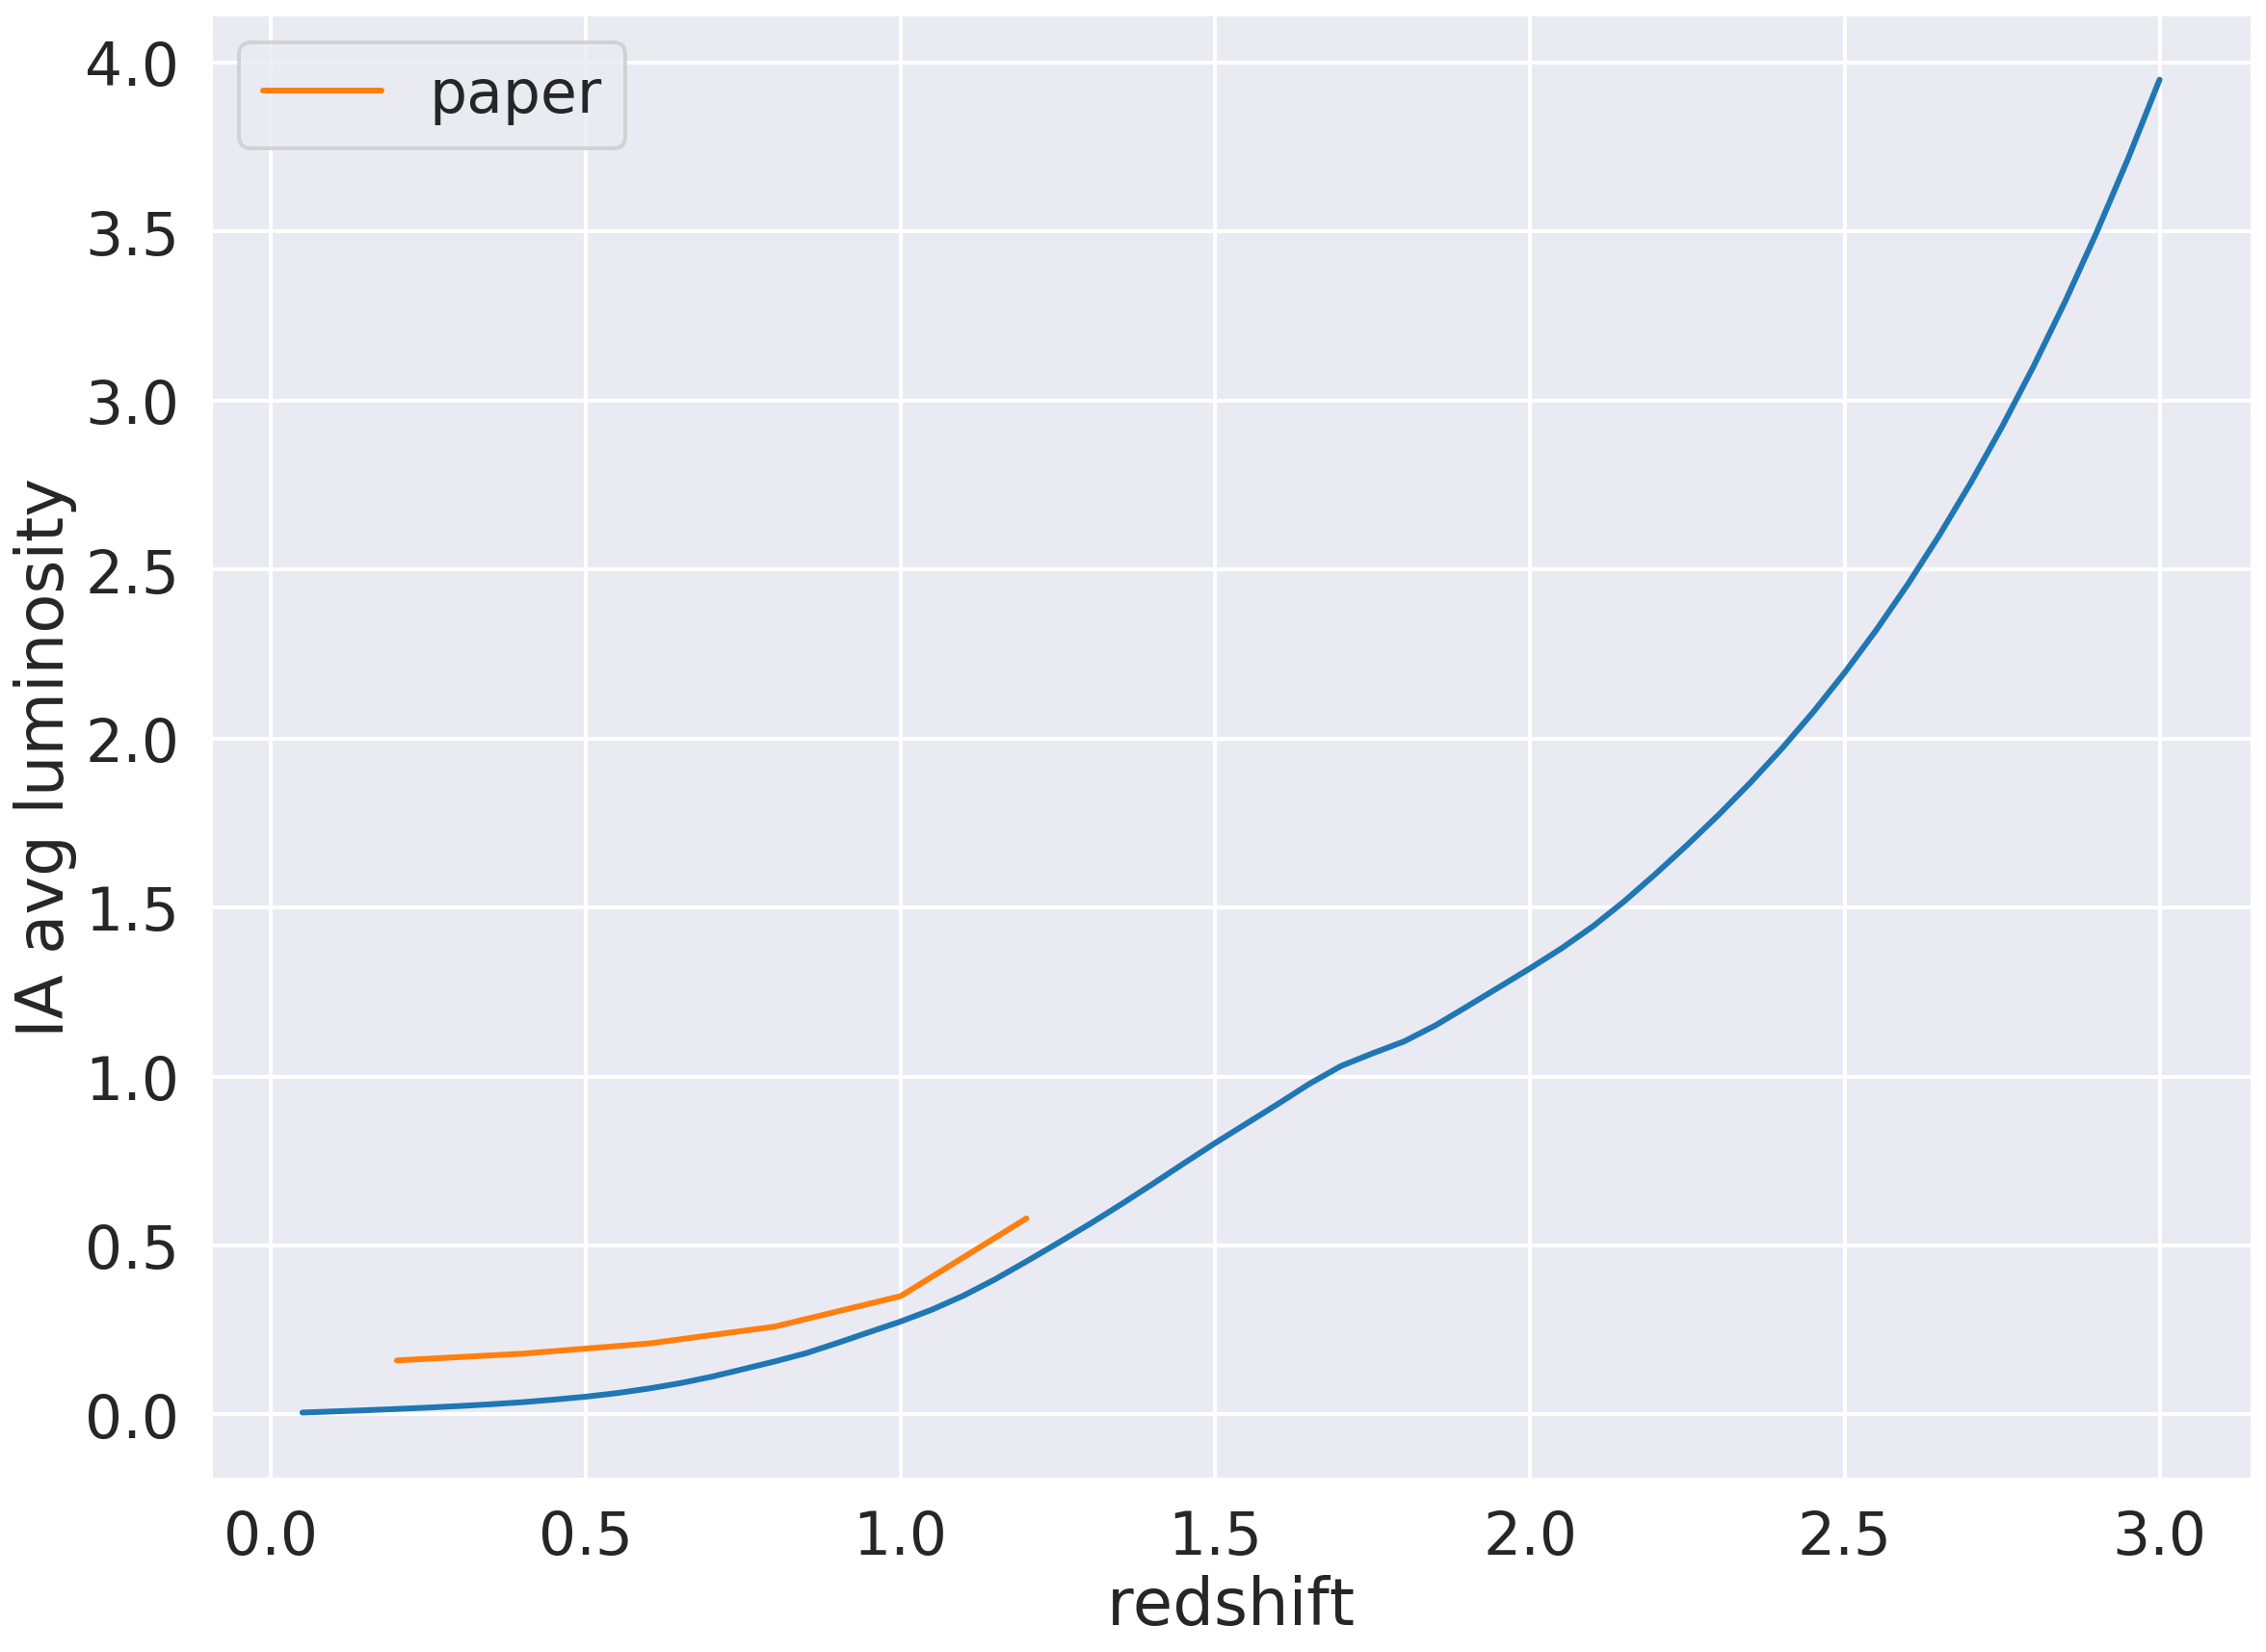

In [6]:


for lum_scale in [1]:#, 0.6, 0.8, 1.1, 1.2, 1.3, 1.4]:
    print('iteration')
    source = Source(z[1:])
    ia = KEBNLASystematic(0, 0, lum_scale)
    ia.apply(cosmo, source)
    plt.plot(source.z_, source.ia_bias_)#, label='beta: {:.1f}'.format(lum_scale))
    plt.plot(paper_z, paper_l, label='paper')
plt.legend()
#plt.yscale('log')
plt.xlabel('redshift')
plt.ylabel('IA avg luminosity ')

iteration


No handles with labels found to put in legend.


Text(0.5, 0, 'redshift')

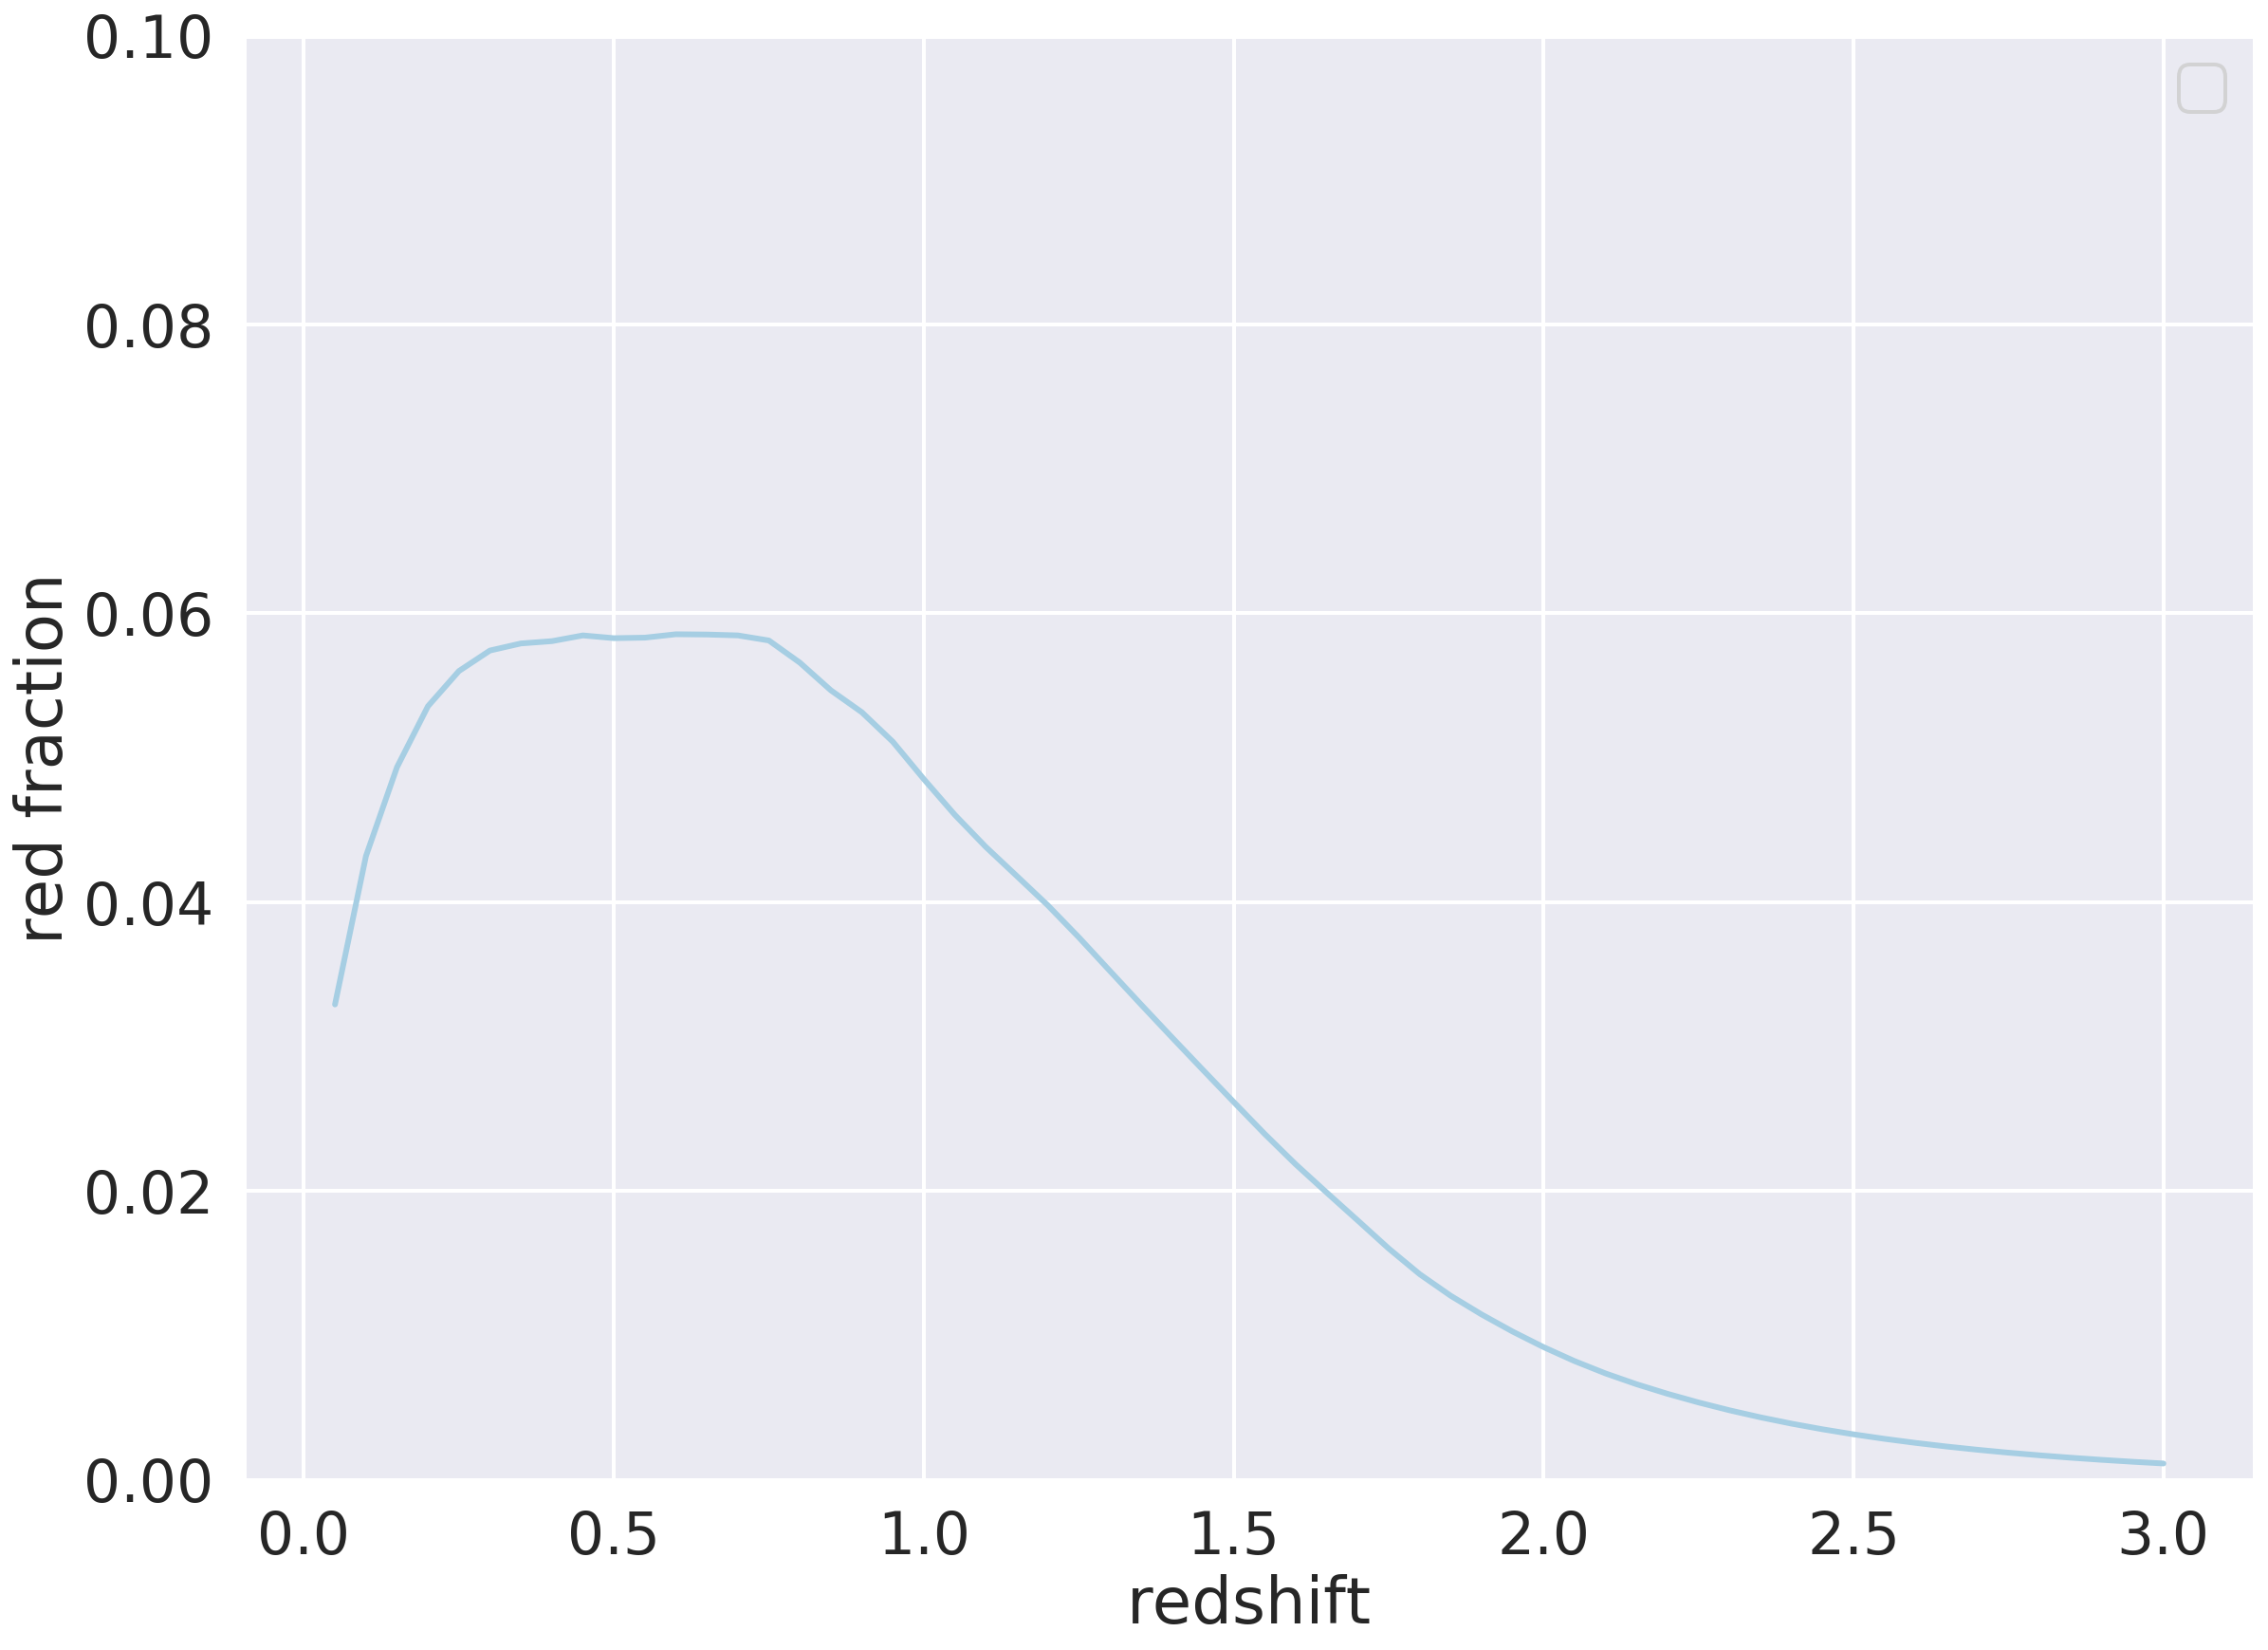

In [14]:
sns.set_palette('Paired')
for lum_scale in [1]:
    print('iteration')
    source = Source(z[1:])
    ia = KEBNLASystematic(0, 0, lum_scale)
    ia.apply(cosmo, source)
    plt.plot(source.z_, source.rf_)#, label='red fraction. beta: {:.1f}'.format(lum_scale))
    #plt.plot(source.z_, source.az_, label='luminosity contrib. beta: {:.1f}'.format(lum_scale))
plt.legend()
plt.ylim((0, 0.1))
#plt.yscale('log')
plt.ylabel('red fraction')
plt.xlabel('redshift')
# I switched MLIM to 27.5 here to compare with keb16 paper
